# ESM3 Use `.pdb` structure file

## My protein structure tokenization processor

In [1]:
!wget https://files.rcsb.org/download/1BEY.cif.gz

--2025-02-13 14:41:43--  https://files.rcsb.org/download/1BEY.cif.gz
Resolving files.rcsb.org (files.rcsb.org)... 108.156.91.39, 108.156.91.23, 108.156.91.31, ...
Connecting to files.rcsb.org (files.rcsb.org)|108.156.91.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88560 (86K) [application/octet-stream]
Saving to: ‘1BEY.cif.gz’

1BEY.cif.gz         100%[===================>]  86.48K  --.-KB/s    in 0.01s   

2025-02-13 14:41:45 (6.01 MB/s) - ‘1BEY.cif.gz’ saved [88560/88560]



In [9]:
import gzip
import torch
import numpy as np
from Bio.PDB import *
from scipy.spatial.transform import Rotation
device = 'cpu'

In [10]:
# Hey Dan, check out this useful readme block on the helper functions to process protein structure data into tokens.
# I'm adding extra comments so we can discuss potential improvements.



Relative orientations between residues:


In addition to distance, the spatial arrangement of residues is critical. We compute the orientation of one residue relative to another. This is done by defining a local coordinate frame for each residue (based on the positions of its backbone atoms like N, CA, and C) and then calculating the relative rotation between these frames.
Instead of using rotation matrices or Euler angles (which can be unwieldy or suffer from issues like gimbal lock), we represent the rotation using a quaternion.

What is a quaternion?
A quaternion is a mathematical construct that extends complex numbers. It has four components and is typically written as:
```
q = w + xi + yj + zk
```
where w, x, y, and z are real numbers. For rotations, we use unit quaternions (quaternions normalized to have a magnitude of 1). They provide a compact, efficient, and robust way to represent rotations in 3D space.
In our scheme, we discretize each of the four quaternion components into a fixed number of bins (say, 8 bins per component). We then combine these four discrete indices (using something like a positional encoding) into a single integer, which we call the quaternion token.

Finally, we combine these two discrete pieces of information into one token that represents both the distance and the relative orientation between two residues. This is done by computing:

  token = (distance_token) × (quat_bins⁴) + (quaternion_token)
  
  
This formulation ensures that each token uniquely corresponds to a specific range of distances and a specific orientation, effectively “quantizing” the continuous geometry of the protein. The neural network can then learn from these tokens instead of raw continuous values.

When we reverse the tokenization process, we perform integer division and modulus operations to recover the original bucket indices. Then we map these indices to the midpoints of their corresponding bins to approximate the original continuous values. This round-trip conversion helps us validate that our discretization scheme retains enough of the structural information for the model to work effectively.""



**the TL;DR**
Quaternions capture the essential orientation information in four numbers that can be efficiently normalized and manipulated. In our context, we discretize these quaternion components to encode the relative orientations between residues as tokens that a model can work with.


https://en.wikipedia.org/wiki/Quaternion

In [10]:
def get_backbone_frames(coords):
    """
    Compute local backbone frames from atomic coordinates.
    
    Dan, does this simple approach (using only N, CA, C) capture the all the structural detail for ESM?
    """
    n_atoms = coords.shape[0]  # number of residues (each with 3 atoms: N, CA, C)

    # Compute vectors along the backbone:
    n_ca = coords[:, 1] - coords[:, 0]  # Vector from N to CA for each residue
    ca_c = coords[:, 2] - coords[:, 1]  # Vector from CA to C for each residue

    # Normalize these vectors to unit length (for consistency)
    n_ca = n_ca / torch.norm(n_ca, dim=-1, keepdim=True)  # Normalize N->CA vectors
    ca_c = ca_c / torch.norm(ca_c, dim=-1, keepdim=True)  # Normalize CA->C vectors

    # Define the frame axes:
    t = ca_c  # The tangent direction along the backbone (from CA to C)
    n = torch.cross(n_ca, ca_c)  # A normal vector from the cross product
    n = n / torch.norm(n, dim=-1, keepdim=True)  # Normalize the normal vector
    b = torch.cross(t, n)  # The binormal vector (perpendicular to both t and n)

    # Stack the axes into a rotation matrix for each residue.
    # The columns of each rotation matrix are: [n, b, t].
    frames = torch.stack([n, b, t], dim=-1)  # Shape: (n_atoms, 3, 3)
    return frames

In [11]:
def get_relative_orientations(frames):
    """
    Compute the relative orientations between all pairs of backbone frames.
    
    Args:
        frames (torch.Tensor): Tensor of shape (n_frames, 3, 3), where each 3x3 matrix
                               is a rotation matrix representing a backbone frame.
    
    Returns:
        torch.Tensor: Tensor of shape (n_frames, n_frames, 4) containing quaternions that 
                      represent the relative rotation from frame i to frame j.
    """
    n_frames = frames.shape[0]

    # Compute relative rotation matrices between all pairs.
    # We use broadcasting to compute: R_rel[i,j] = frames[i] * frames[j]^T
    rel_rots = torch.matmul(frames.unsqueeze(1), frames.transpose(-2, -1).unsqueeze(0))
    
    # Convert each relative rotation matrix to a quaternion.
    # Note: This loop might be a performance bottleneck for many large proteins.
    rel_quats = torch.zeros((n_frames, n_frames, 4), device=frames.device)
    for i in range(n_frames):
        for j in range(n_frames):
            # Convert the rotation matrix to a numpy array and then to a quaternion.
            r = Rotation.from_matrix(rel_rots[i, j].cpu().numpy())  # Dan, is it okay to move to CPU here?
            rel_quats[i, j] = torch.tensor(r.as_quat(), device=frames.device)
    return rel_quats

In [12]:
def structure_to_tokens(coords, max_radius=20.0, n_bins=50):
    """
    Convert structure information into tokens for the ESM model.
    
    This function computes pairwise CA distances and relative orientations between residues,
    discretizes these continuous values into bins, and then combines them into a single token.
    
    Args:
        coords (torch.Tensor): Tensor of shape (n_residues, 3, 3) containing atomic coordinates
                               for N, CA, C atoms of each residue.
        max_radius (float): Maximum distance for binning CA-CA distances.
        n_bins (int): Number of bins to discretize the distances.
    
    Returns:
        torch.Tensor: Tensor of discretized tokens representing the structure.

    """
    # Get CA coordinates (assuming CA is the second atom, index 1)
    ca_coords = coords[:, 1]  # Shape: (n_residues, 3)
    dists = torch.cdist(ca_coords, ca_coords)  # Compute pairwise Euclidean distances

    # Compute backbone frames and then relative orientations
    frames = get_backbone_frames(coords)  # Each residue's local frame
    orientations = get_relative_orientations(frames)  # Relative orientations as quaternions

    # Discretize distances into bins
    dist_bins = torch.linspace(0, max_radius, n_bins, device=coords.device)
    # bucketize returns indices of the bins for each distance
    dist_tokens = torch.bucketize(dists.flatten(), dist_bins).reshape(dists.shape)

    # Discretize orientations (quaternions) into bins per component.
    quat_bins = 8  # Number of bins per quaternion component (see wiki plink)
    
    # Scale quaternions from [-1, 1] to [0, quat_bins] and take the floor to get bin indices.
    quat_tokens = torch.floor((orientations + 1) * quat_bins / 2).long()  # Each component binned
    
    # Combine the 4 quaternion components into a single token via a positional encoding scheme.
    quat_tokens = (quat_tokens[..., 0] * quat_bins**3 +
                   quat_tokens[..., 1] * quat_bins**2 +
                   quat_tokens[..., 2] * quat_bins +
                   quat_tokens[..., 3])
    
    # Combine the discretized distance tokens and quaternion tokens.
    # The distance token is weighted by quat_bins**4 to ensure unique combinations.
    structure_tokens = dist_tokens * quat_bins**4 + quat_tokens
    return structure_tokens

In [59]:
# --------------------------
# Load and process structure
# --------------------------
# Dan, here I'm loading a structure from a compressed CIF file

parser = MMCIFParser()
fpath = '/home/jupyter/DATA/hyperbind_train/pdb/1BEY.cif.gz'
with gzip.open(fpath, 'rt') as f:
    structure = parser.get_structure('1BEY', f)

# Extract backbone coordinates from the structure.
# We iterate over models and chains, and here I'm filtering for chain 'H' (as an example).
# Dan, should we generalize this to select a chain dynamically?
coords = []
for model in structure:
    for chain in model:
        # Instead of comparing chain directly to 'H', it's better to use chain.get_id()
        if chain.get_id() == 'H':  # Dan, does chain 'H' make sense for our case?
            backbone = []
            for residue in chain:
                # Check if residue has all the required backbone atoms: N, CA, and C.
                if all(atom in residue for atom in ['N', 'CA', 'C']):
                    # Append the coordinates for N, CA, and C.
                    backbone.append([
                        residue['N'].get_coord(),  # Coordinates for N atom
                        residue['CA'].get_coord(), # Coordinates for CA atom
                        residue['C'].get_coord()   # Coordinates for C atom
                    ])
            # Only add the backbone if we found valid residues.
            if backbone:
                coords.append(backbone)

# Convert the list of coordinates to a torch tensor.
# Dan, note: this tensor will have shape (num_chains, num_residues, 3, 3).
# You might want to select one chain if needed.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
coords = torch.tensor(coords, dtype=torch.float32).to(device)

# For simplicity, let's assume we only work with the first chain extracted.
coords = coords[0]  # Now shape is (n_residues, 3, 3)
print("Backbone coordinate tensor shape:", coords.shape)

# Convert the structure into tokens using our tokenization function.
structure_tokens = structure_to_tokens(coords)
print("Structure tokens shape:", structure_tokens.shape)
print("Structure tokens:", structure_tokens)

Backbone coordinate tensor shape: torch.Size([210, 3, 3])
Structure tokens shape: torch.Size([210, 210])
Structure tokens: tensor([[  2344,  42151,  75451,  ..., 208356, 206300, 208747],
        [ 43871,   2344,  42443,  ..., 208297, 206315, 208665],
        [ 75452,  42444,   2344,  ..., 208467, 208225, 206315],
        ...,
        [208355, 208302, 208468,  ...,   2344,  42298,  67383],
        [206299, 206316, 208230,  ...,  42301,   2344,  42811],
        [208748, 208670, 206316,  ...,  67791,  42812,   2344]],
       device='cuda:0')


In [62]:
structure_tokens

tensor([[  2344,  42151,  75451,  ..., 208356, 206300, 208747],
        [ 43871,   2344,  42443,  ..., 208297, 206315, 208665],
        [ 75452,  42444,   2344,  ..., 208467, 208225, 206315],
        ...,
        [208355, 208302, 208468,  ...,   2344,  42298,  67383],
        [206299, 206316, 208230,  ...,  42301,   2344,  42811],
        [208748, 208670, 206316,  ...,  67791,  42812,   2344]],
       device='cuda:0')

## A version of teh above fit for ESM3 is below, fitting its tesor requirements

In [63]:
# For tokenization, ESM3 expects a tensor of shape (L, 37, 3) where L is the number of residues.
# Here we define a simple helper that extracts the N, CA, and C atoms from each residue 
# and pads the remaining positions with a large value (here, infinity) as a placeholder.
# (In practice, a full conversion should fill in all 37 atom positions.)

import torch
import numpy as np

def convert_structure_to_atom37(structure, chain_id):
    # Extract the first structure model and the specified chain
    model = next(structure.get_models())
    chain = model[chain_id]
    residues = list(chain.get_residues())
    L = len(residues)
    
    # Create an array of shape (L, 37, 3) filled with a high value (to indicate missing atoms)
    atom37 = np.full((L, 37, 3), np.inf, dtype=np.float32)
    # For demonstration, fill only the first three positions with N, CA, and C coordinates
    for i, residue in enumerate(residues):
        try:
            atom37[i, 0] = residue['N'].get_coord()
            atom37[i, 1] = residue['CA'].get_coord()
            atom37[i, 2] = residue['C'].get_coord()
        except KeyError:
            # If any of these atoms are missing, we leave the row as is.
            continue
    return atom37


chain_id = 'H'
atom37_coords = convert_structure_to_atom37(structure, chain_id)
print("Atom37 coordinates shape:", atom37_coords.shape)

Atom37 coordinates shape: (210, 37, 3)


In [65]:
atom37_coords

210

In [17]:
type(structure)

Bio.PDB.Structure.Structure

## import module version

In [18]:
import os, sys

scripts_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "scripts"))

# Add the "scripts" directory to the Python path if it's not already present.
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

In [19]:
from structure_tokenization import convert_structure_to_atom37
from structure_tokenization import convert_structure_to_atom37_all

In [48]:
tokens = convert_structure_to_atom37(structure, chain_id='H')

In [78]:
print(tokens.shape)
print(tokens)

(210, 37, 3)
[[[ 7.929 79.104 42.518]
  [ 6.897 79.705 43.426]
  [ 7.205 79.372 44.891]
  ...
  [   inf    inf    inf]
  [   inf    inf    inf]
  [   inf    inf    inf]]

 [[ 6.715 78.186 45.269]
  [ 6.801 77.592 46.599]
  [ 7.716 76.363 46.672]
  ...
  [   inf    inf    inf]
  [   inf    inf    inf]
  [   inf    inf    inf]]

 [[ 8.269 76.103 47.849]
  [ 9.18  74.978 48.013]
  [ 8.849 74.05  49.195]
  ...
  [   inf    inf    inf]
  [   inf    inf    inf]
  [   inf    inf    inf]]

 ...

 [[33.28  63.064 39.117]
  [34.236 62.546 38.163]
  [34.165 63.25  36.793]
  ...
  [   inf    inf    inf]
  [   inf    inf    inf]
  [   inf    inf    inf]]

 [[35.319 63.38  36.143]
  [35.452 64.002 34.836]
  [35.456 62.881 33.796]
  ...
  [   inf    inf    inf]
  [   inf    inf    inf]
  [   inf    inf    inf]]

 [[34.38  62.671 33.056]
  [34.421 61.614 32.055]
  [35.18  62.107 30.838]
  ...
  [   inf    inf    inf]
  [   inf    inf    inf]
  [   inf    inf    inf]]]


In [84]:
tokens = convert_structure_to_atom37_all(structure)

In [85]:
print(tokens.shape)
print(tokens)

(425, 37, 3)
[[[-11.979  53.307  56.156]
  [-11.409  53.134  54.804]
  [-12.566  52.994  53.833]
  ...
  [    inf     inf     inf]
  [    inf     inf     inf]
  [    inf     inf     inf]]

 [[-12.364  53.415  52.584]
  [-13.404  53.313  51.562]
  [-12.719  52.897  50.278]
  ...
  [    inf     inf     inf]
  [    inf     inf     inf]
  [    inf     inf     inf]]

 [[-12.207  51.675  50.269]
  [-11.495  51.106  49.123]
  [-11.804  51.816  47.805]
  ...
  [    inf     inf     inf]
  [    inf     inf     inf]
  [    inf     inf     inf]]

 ...

 [[ 33.28   63.064  39.117]
  [ 34.236  62.546  38.163]
  [ 34.165  63.25   36.793]
  ...
  [    inf     inf     inf]
  [    inf     inf     inf]
  [    inf     inf     inf]]

 [[ 35.319  63.38   36.143]
  [ 35.452  64.002  34.836]
  [ 35.456  62.881  33.796]
  ...
  [    inf     inf     inf]
  [    inf     inf     inf]
  [    inf     inf     inf]]

 [[ 34.38   62.671  33.056]
  [ 34.421  61.614  32.055]
  [ 35.18   62.107  30.838]
  ...
  [    inf 

# Create pdb structure tokenization data pipeline leveraging `ESM` + `OpenFold` #

In [69]:
!wget https://files.rcsb.org/download/1BEY.pdb

--2025-02-13 16:50:41--  https://files.rcsb.org/download/1BEY.pdb
Resolving files.rcsb.org (files.rcsb.org)... 52.84.125.11, 52.84.125.116, 52.84.125.12, ...
Connecting to files.rcsb.org (files.rcsb.org)|52.84.125.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘1BEY.pdb’

1BEY.pdb                [ <=>                ] 296.31K  --.-KB/s    in 0.06s   

2025-02-13 16:50:42 (5.14 MB/s) - ‘1BEY.pdb’ saved [303426]



In [66]:
from esm.utils.structure.protein_chain import ProteinChain

In [71]:
fpath = '/home/jupyter/1BEY.pdb'
protein_chain = ProteinChain.from_pdb(path=fpath)
atom37 = protein_chain.atom37_positions

In [99]:
atom37

array([[[-11.979,  53.307,  56.156],
        [-11.409,  53.134,  54.804],
        [-12.566,  52.994,  53.833],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[-12.364,  53.415,  52.584],
        [-13.404,  53.313,  51.562],
        [-12.719,  52.897,  50.278],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[-12.207,  51.675,  50.269],
        [-11.495,  51.106,  49.123],
        [-11.804,  51.816,  47.805],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       ...,

       [[ 42.462,  45.96 ,  22.864],
        [ 43.336,  46.91 ,  22.193],
        [ 44.516,  47.378,  23.027],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[ 45.003,  46.529,  23.921],
  

In [86]:
atom37

array([[[-11.979,  53.307,  56.156],
        [-11.409,  53.134,  54.804],
        [-12.566,  52.994,  53.833],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[-12.364,  53.415,  52.584],
        [-13.404,  53.313,  51.562],
        [-12.719,  52.897,  50.278],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[-12.207,  51.675,  50.269],
        [-11.495,  51.106,  49.123],
        [-11.804,  51.816,  47.805],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       ...,

       [[ 42.462,  45.96 ,  22.864],
        [ 43.336,  46.91 ,  22.193],
        [ 44.516,  47.378,  23.027],
        ...,
        [    nan,     nan,     nan],
        [    nan,     nan,     nan],
        [    nan,     nan,     nan]],

       [[ 45.003,  46.529,  23.921],
  

In [88]:
tokens

array([[[-11.979,  53.307,  56.156],
        [-11.409,  53.134,  54.804],
        [-12.566,  52.994,  53.833],
        ...,
        [    inf,     inf,     inf],
        [    inf,     inf,     inf],
        [    inf,     inf,     inf]],

       [[-12.364,  53.415,  52.584],
        [-13.404,  53.313,  51.562],
        [-12.719,  52.897,  50.278],
        ...,
        [    inf,     inf,     inf],
        [    inf,     inf,     inf],
        [    inf,     inf,     inf]],

       [[-12.207,  51.675,  50.269],
        [-11.495,  51.106,  49.123],
        [-11.804,  51.816,  47.805],
        ...,
        [    inf,     inf,     inf],
        [    inf,     inf,     inf],
        [    inf,     inf,     inf]],

       ...,

       [[ 33.28 ,  63.064,  39.117],
        [ 34.236,  62.546,  38.163],
        [ 34.165,  63.25 ,  36.793],
        ...,
        [    inf,     inf,     inf],
        [    inf,     inf,     inf],
        [    inf,     inf,     inf]],

       [[ 35.319,  63.38 ,  36.143],
  

In [98]:
print(atom37.shape)
print(tokens[0:214].shape)
print('our atom37')
print(tokens[0][0:5])
print('atom37')
print(atom37[0][0:5])

(214, 37, 3)
(214, 37, 3)
our atom37
[[-11.979  53.307  56.156]
 [-11.409  53.134  54.804]
 [-12.566  52.994  53.833]
 [    inf     inf     inf]
 [    inf     inf     inf]]
atom37
[[-11.979  53.307  56.156]
 [-11.409  53.134  54.804]
 [-12.566  52.994  53.833]
 [-10.548  51.882  54.788]
 [-13.638  52.533  54.223]]


# *Validate our structure tokenization is correct by doing a round-trip conversion*

The tokenization:
  token = distance_token * (quat_bins**4) + quaternion_token

where:
  - distance_token is the bin index for the CA-CA distance (bucketized over [0, max_radius])
  - quaternion_token encodes 4 quaternion components, each discretized into quat_bins values

This function extracts these two components from each token and then maps them back 
to approximate continuous values using the midpoints of the bins.

Note: Because we discretize continuous values, this reverse process is gonna be lossy

In [52]:
def reverse_structure_tokens_debug(structure_tokens, max_radius=20.0, n_bins=50, quat_bins=8):
    '''
    Reverse the structure tokenization to recover approximate continuous values.
    Debug version with print statements to trace intermediate values.

    Parameters:
    structure_tokens (torch.Tensor): Integer tensor of tokens (e.g., from structure_to_tokens).
    max_radius (float): Maximum CA-CA distance used during tokenization.
    n_bins (int): Number of distance bins.
    quat_bins (int): Number of bins per quaternion component.

    Returns:
    approx_dists (torch.Tensor): Approximate distances recovered from the tokens.
    approx_quats (torch.Tensor): Approximate quaternions (last dim=4) recovered from the tokens.
    '''
    
    print("=== Starting reverse_structure_tokens_debug ===")
    print("Input structure_tokens:")
    print(structure_tokens)
    print("dtype:", structure_tokens.dtype, "shape:", structure_tokens.shape)
    
    # Compute distance token and quaternion token components.
    
    
    
    
    dist_token = (structure_tokens // (quat_bins ** 4)).long()  # <-- distance token component
    quat_token = (structure_tokens % (quat_bins ** 4)).long()    # <-- quaternion token component
    print("\nAfter division and modulus:")
    print("dist_token (raw):")
    print(dist_token)
    print("quat_token (raw):")
    print(quat_token)
    
    # Clamp to avoid negative indices (debug print clamped values)
    dist_token = torch.clamp(dist_token, min=0)
    quat_token = torch.clamp(quat_token, min=0)
    print("\nAfter clamping:")
    print("dist_token (clamped):", dist_token)
    print("quat_token (clamped):", quat_token)
    
    # Create linear bins for distances between 0 and max_radius
    dist_bins = torch.linspace(0, max_radius, n_bins, device=structure_tokens.device)
    print("\nDistance bins (dist_bins):", dist_bins)
    
    bin_width = dist_bins[1] - dist_bins[0]  # Width of each bin
    print("Bin width:", bin_width.item())
    
    # Compute midpoints for each distance bin
    dist_midpoints = dist_bins - bin_width / 2  # Simple approximation
    dist_midpoints = torch.clamp(dist_midpoints, min=0)  # Ensure no negative distances
    print("Distance midpoints:", dist_midpoints)
    
    # Map each distance token index back to its corresponding midpoint
    approx_dists = dist_midpoints[dist_token]  # Reconstructed distance values
    print("\nApproximate distances (approx_dists):", approx_dists)
    
    # Decode the quaternion token into 4 components.
    q0 = quat_token // (quat_bins ** 3)                        # first component
    remainder = quat_token % (quat_bins ** 3)
    q1 = remainder // (quat_bins ** 2)                         # second component
    remainder = remainder % (quat_bins ** 2)
    q2 = remainder // quat_bins                                # third component
    q3 = remainder % quat_bins                                 # fourth component
    print("\nDecoded quaternion component indices:")
    print("q0:", q0)
    print("q1:", q1)
    print("q2:", q2)
    print("q3:", q3)
    
    # Create bins for quaternion components in the range [-1, 1]
    bin_edges = torch.linspace(-1, 1, quat_bins + 1, device=structure_tokens.device)
    print("\nQuaternion bin edges:", bin_edges)
    
    # Calculate midpoints for these bins
    quat_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2  # Each midpoint represents a value
    print("Quaternion midpoints:", quat_midpoints)
    
    # Map each discrete quaternion component to its approximate continuous value
    approx_q0 = quat_midpoints[q0]  # first quaternion component
    approx_q1 = quat_midpoints[q1]  # second component
    approx_q2 = quat_midpoints[q2]  # third component
    approx_q3 = quat_midpoints[q3]  # fourth component
    print("\nRecovered quaternion components:")
    print("approx_q0:", approx_q0)
    print("approx_q1:", approx_q1)
    print("approx_q2:", approx_q2)
    print("approx_q3:", approx_q3)
    
    # Stack the four components into a single tensor; the last dimension becomes size 4
    approx_quats = torch.stack([approx_q0, approx_q1, approx_q2, approx_q3], dim=-1)
    print("\nFinal recovered quaternions (approx_quats):", approx_quats)
    
    print("=== Finished reverse_structure_tokens_debug ===")
    return approx_dists, approx_quats

In [52]:
# -----------------------------------------------------------------------------
# Example usage:
# -----------------------------------------------------------------------------
# Ensure that 'tokens' is a numpy array of integer tokens. Convert to a tensor.
tokens_tensor = torch.tensor(tokens, device=torch.device("cpu"))
approx_dists, approx_quats = reverse_structure_tokens_debug(tokens_tensor)

=== Starting reverse_structure_tokens_debug ===
Input structure_tokens:
tensor([[[ 7.9290, 79.1040, 42.5180],
         [ 6.8970, 79.7050, 43.4260],
         [ 7.2050, 79.3720, 44.8910],
         ...,
         [    inf,     inf,     inf],
         [    inf,     inf,     inf],
         [    inf,     inf,     inf]],

        [[ 6.7150, 78.1860, 45.2690],
         [ 6.8010, 77.5920, 46.5990],
         [ 7.7160, 76.3630, 46.6720],
         ...,
         [    inf,     inf,     inf],
         [    inf,     inf,     inf],
         [    inf,     inf,     inf]],

        [[ 8.2690, 76.1030, 47.8490],
         [ 9.1800, 74.9780, 48.0130],
         [ 8.8490, 74.0500, 49.1950],
         ...,
         [    inf,     inf,     inf],
         [    inf,     inf,     inf],
         [    inf,     inf,     inf]],

        ...,

        [[33.2800, 63.0640, 39.1170],
         [34.2360, 62.5460, 38.1630],
         [34.1650, 63.2500, 36.7930],
         ...,
         [    inf,     inf,     inf],
         [    in

In [51]:
tokens_tensor.shape

torch.Size([210, 37, 3])

In [50]:
# -----------------------------------------------------------------------------
# Example usage:
# -----------------------------------------------------------------------------
tokens_tensor = torch.tensor(tokens, device=torch.device("cpu")) # go to tensor form
approx_dists, approx_quats = reverse_structure_tokens(tokens_tensor) # testing our tokens
print("Approximate distances (recovered from tokens):")
print(approx_dists)  # Should be a tensor of the same shape as dummy_tokens // (quat_bins**4)
print("\nApproximate quaternions (last dim=4):")
print(approx_quats)  # Tensor with shape (10, 10, 4)

Approximate distances (recovered from tokens):
tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

Approximate qu

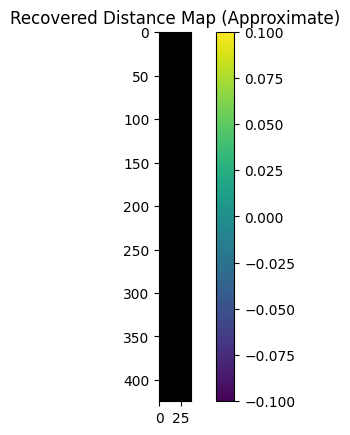

In [45]:
# Optionally, visualize the recovered distance map (this is just for debugging)
plt.imshow(approx_dists.cpu().numpy(), cmap='viridis')
plt.title("Recovered Distance Map (Approximate)")
plt.colorbar()
plt.show()

# More tests could include comparing these recovered values with the original continuous ones,
# but remember, due to discretization, some loss is expected.